In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

plt.style.use(r'customStyle')

# data processing
import loader as load

#import the working methods
import tensorflow as tf
print("TensorFlow version ",tf.__version__)

from tensorflow import keras


from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

TensorFlow version  2.18.0


In [12]:
#--------- globals

# Need to see a large portion of the data before we can build a layer, for
# example half of data n_batches_per_layer =  NBATCH_FRAC * NUM_EXAMPLES / BATCH_SIZE
BATCH_SIZE = 1000

# Seed value
# Apparently you may use different seed values at each stage
SEED_VALUE= 10001
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED_VALUE)

In [13]:
def main(nepoch=10):
    DATA_PATH = r"data/higgs-parsed.h5"

    hdata = load.load_data_from_path(DATA_PATH) 
    data_fnames = hdata['feature_names'].to_numpy()[1:]
    n_dims = data_fnames.shape[0]
    print("Entries read {} with feature names {}".format(n_dims, data_fnames))

    def split_xy_noscale(df):
        y = df['hlabel']                       # labels: 0=bkg, 1=sig
        X = df.drop(['hlabel'], axis=1)        # features
        return X, y

    x_trn_raw, y_trn = split_xy_noscale(hdata['train'])
    x_train_raw, x_test_raw, y_train, y_test = train_test_split(
        x_trn_raw, y_trn, test_size=0.1, stratify=y_trn, random_state=42
    )
    x_val_raw, y_val = split_xy_noscale(hdata['valid'])

    scaler = MinMaxScaler().fit(x_train_raw)

    def _tf(scaler, X):
        Xt = scaler.transform(X)
        return pd.DataFrame(Xt, columns=X.columns, index=X.index)

    x_train = _tf(scaler, x_train_raw)
    x_test  = _tf(scaler, x_test_raw)
    x_val   = _tf(scaler, x_val_raw)

    # ready the data for TF
    ds_train = tf.data.Dataset.from_tensor_slices((x_train.to_numpy(),y_train.to_numpy().reshape(-1, 1)))
    ds_train = ds_train.repeat()
    ds_train = ds_train.batch(BATCH_SIZE,drop_remainder=True)

    ds_test = tf.data.Dataset.from_tensor_slices((x_test.to_numpy(),y_test.to_numpy().reshape(-1, 1)))
    ds_test = ds_test.repeat()
    ds_test = ds_test.batch(BATCH_SIZE,drop_remainder=True)

    train_steps=int(x_train.shape[0]/BATCH_SIZE)
    test_steps=int(x_test.shape[0]/BATCH_SIZE)
    print("Steps train:{} and test:{}".format(train_steps,test_steps))


    dnn = Sequential()
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(50, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid'))

    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', 'AUC', 'binary_crossentropy'])

    dnn.summary()

    dnn_model_history = dnn.fit(ds_train,
            epochs=nepoch,
            steps_per_epoch=train_steps,
            validation_data=ds_test,
            validation_steps=test_steps,
        )

    print("history values",dnn_model_history.history.keys())

    y_score=dnn.predict(x_val.to_numpy())[:,0]
    auc=roc_auc_score(y_val,y_score)
    print("AUC score: {}".format(auc))


In [14]:
main(50)
# 0.8139

Loading data/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Steps train:360 and test:40


/home/tilen/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 50)             │           950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,551 (13.87 KB)

 Trainable params: 3,551 (13.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5811 - accuracy: 0.5604 - binary_crossentropy: 0.6780 - loss: 0.6780 - val_AUC: 0.6797 - val_accuracy: 0.6292 - val_binary_crossentropy: 0.6375 - val_loss: 0.6375
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6837 - accuracy: 0.6328 - binary_crossentropy: 0.6358 - loss: 0.6358 - val_AUC: 0.7018 - val_accuracy: 0.6461 - val_binary_crossentropy: 0.6252 - val_loss: 0.6252
Epoch 3/50
341/360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7041 - accuracy: 0.6493 - binary_crossentropy: 0.6245 - loss: 0.6245

KeyboardInterrupt: 

In [45]:
def main2(nepoch=100):
    DATA_PATH = r"data/higgs-parsed.h5"

    hdata = load.load_data_from_path(DATA_PATH) 
    data_fnames = hdata['feature_names'].to_numpy()[1:]
    n_dims = data_fnames.shape[0]
    print("Entries read {} with feature names {}".format(n_dims, data_fnames))

    def split_xy_noscale(df):
        y = df['hlabel']                       # labels: 0=bkg, 1=sig
        X = df.drop(['hlabel'], axis=1)        # features
        return X, y

    x_trn_raw, y_trn = split_xy_noscale(hdata['train'])
    x_train_raw, x_test_raw, y_train, y_test = train_test_split(
        x_trn_raw, y_trn, test_size=0.1, stratify=y_trn, random_state=42
    )
    x_val_raw, y_val = split_xy_noscale(hdata['valid'])

    scaler = MinMaxScaler().fit(x_train_raw)

    def _tf(scaler, X):
        Xt = scaler.transform(X)
        return pd.DataFrame(Xt, columns=X.columns, index=X.index)

    x_train = _tf(scaler, x_train_raw)
    x_test  = _tf(scaler, x_test_raw)
    x_val   = _tf(scaler, x_val_raw)

    # ready the data for TF
    ds_train = tf.data.Dataset.from_tensor_slices((x_train.to_numpy(),y_train.to_numpy().reshape(-1, 1)))
    ds_train = ds_train.repeat()
    ds_train = ds_train.batch(BATCH_SIZE,drop_remainder=True)

    ds_test = tf.data.Dataset.from_tensor_slices((x_test.to_numpy(),y_test.to_numpy().reshape(-1, 1)))
    ds_test = ds_test.repeat()
    ds_test = ds_test.batch(BATCH_SIZE,drop_remainder=True)

    train_steps=int(x_train.shape[0]/BATCH_SIZE)
    test_steps=int(x_test.shape[0]/BATCH_SIZE)
    print("Steps train:{} and test:{}".format(train_steps,test_steps))


    dnn = Sequential()
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    # dnn.add(BatchNormalization())
    dnn.add(Dropout(0.2))
    dnn.add(Dense(50, activation='relu'))
    # dnn.add(BatchNormalization())
    dnn.add(Dropout(0.2))
    dnn.add(Dense(1, activation='sigmoid'))

    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', 'AUC', 'binary_crossentropy'])

    dnn.summary()

    early_stopping = EarlyStopping(
        monitor='val_loss',
        min_delta=0.00001,
        patience=10,
        restore_best_weights=True
        )

    lr_scheduler = ReduceLROnPlateau(
        initial_lr=0.01,
        monitor='val_loss', 
        factor=0.5, 
        patience=5
        )


    dnn_model_history = dnn.fit(ds_train,
            epochs=nepoch,
            steps_per_epoch=train_steps,
            callbacks=[early_stopping, lr_scheduler,],
            validation_data=ds_test,
            validation_steps=test_steps,
        )


    print("history values",dnn_model_history.history.keys())

    y_score=dnn.predict(x_val.to_numpy())[:,0]
    auc=roc_auc_score(y_val,y_score)
    print("AUC score: {}".format(auc))


In [46]:
main2()
# 0.812

Loading data/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Steps train:360 and test:40


/home/tilen/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_132 (Dense)               │ (None, 50)             │           950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,551 (13.87 KB)

 Trainable params: 3,551 (13.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5770 - accuracy: 0.5610 - binary_crossentropy: 0.6792 - loss: 0.6792 - val_AUC: 0.6737 - val_accuracy: 0.6196 - val_binary_crossentropy: 0.6422 - val_loss: 0.6422 - learning_rate: 0.0010
Epoch 2/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6657 - accuracy: 0.6194 - binary_crossentropy: 0.6447 - loss: 0.6447 - val_AUC: 0.6958 - val_accuracy: 0.6355 - val_binary_crossentropy: 0.6288 - val_loss: 0.6288 - learning_rate: 0.0010
Epoch 3/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6898 - accuracy: 0.6371 - binary_crossentropy: 0.6325 - loss: 0.6325 - val_AUC: 0.7161 - val_accuracy: 0.6537 - val_binary_crossentropy: 0.6171 - val_loss: 0.6171 - learning_rate: 0.0010
Epoch 4/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7078 - accuracy: 0.6509 - binary_crossentropy: 0.6221 - loss: 0.6221 - val_AUC: 0.7303 - val_accuracy: 0.6691 - val_binary_crossentropy: 0.6065 - val_loss: 0.6065 - learning_rate: 0.0010
Epoc

In [67]:
def main3(nepoch=100):
    DATA_PATH = r"data/higgs-parsed.h5"

    hdata = load.load_data_from_path(DATA_PATH) 
    data_fnames = hdata['feature_names'].to_numpy()[1:]
    n_dims = data_fnames.shape[0]
    print("Entries read {} with feature names {}".format(n_dims, data_fnames))

    def split_xy_noscale(df):
        y = df['hlabel']                       # labels: 0=bkg, 1=sig
        X = df.drop(['hlabel'], axis=1)        # features
        return X, y

    x_trn_raw, y_trn = split_xy_noscale(hdata['train'])
    x_train_raw, x_test_raw, y_train, y_test = train_test_split(
        x_trn_raw, y_trn, test_size=0.1, stratify=y_trn, random_state=42
    )
    x_val_raw, y_val = split_xy_noscale(hdata['valid'])

    scaler = MinMaxScaler().fit(x_train_raw)

    def _tf(scaler, X):
        Xt = scaler.transform(X)
        return pd.DataFrame(Xt, columns=X.columns, index=X.index)

    x_train = _tf(scaler, x_train_raw)
    x_test  = _tf(scaler, x_test_raw)
    x_val   = _tf(scaler, x_val_raw)

    # ready the data for TF
    ds_train = tf.data.Dataset.from_tensor_slices((x_train.to_numpy(),y_train.to_numpy().reshape(-1, 1)))
    ds_train = ds_train.repeat()
    ds_train = ds_train.batch(BATCH_SIZE,drop_remainder=True)

    ds_test = tf.data.Dataset.from_tensor_slices((x_test.to_numpy(),y_test.to_numpy().reshape(-1, 1)))
    ds_test = ds_test.repeat()
    ds_test = ds_test.batch(BATCH_SIZE,drop_remainder=True)

    train_steps=int(x_train.shape[0]/BATCH_SIZE)
    test_steps=int(x_test.shape[0]/BATCH_SIZE)
    print("Steps train:{} and test:{}".format(train_steps,test_steps))


    dnn = Sequential()
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(50, activation='relu'))
    dnn.add(Dense(50, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid'))

    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', 'AUC', 'binary_crossentropy'])

    dnn.summary()

    dnn_model_history = dnn.fit(ds_train,
            epochs=nepoch,
            steps_per_epoch=train_steps,
            validation_data=ds_test,
            validation_steps=test_steps,
        )

    print("history values",dnn_model_history.history.keys())

    y_score=dnn.predict(x_val.to_numpy())[:,0]
    auc=roc_auc_score(y_val,y_score)
    print("AUC score: {}".format(auc))


In [ ]:
main3()
# 0.8214

Loading data/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Steps train:360 and test:40


/home/tilen/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_157 (Dense)               │ (None, 50)             │           950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,101 (23.83 KB)

 Trainable params: 6,101 (23.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5970 - accuracy: 0.5709 - binary_crossentropy: 0.6721 - loss: 0.6721 - val_AUC: 0.6841 - val_accuracy: 0.6325 - val_binary_crossentropy: 0.6347 - val_loss: 0.6347
Epoch 2/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6861 - accuracy: 0.6360 - binary_crossentropy: 0.6340 - loss: 0.6340 - val_AUC: 0.7068 - val_accuracy: 0.6502 - val_binary_crossentropy: 0.6219 - val_loss: 0.6219
Epoch 3/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7088 - accuracy: 0.6526 - binary_crossentropy: 0.6212 - loss: 0.6212 - val_AUC: 0.7244 - val_accuracy: 0.6635 - val_binary_crossentropy: 0.6100 - val_loss: 0.6100
Epoch 4/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7277 - accuracy: 0.6659 - binary_crossentropy: 0.6081 - loss: 0.6081 - val_AUC: 0.7423 - val_accuracy: 0.6783 - val_binary_crossentropy: 0.5964 - val_loss: 0.5964
Epoch 5/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7428 - accuracy: 0.6776 - binary_cross

116


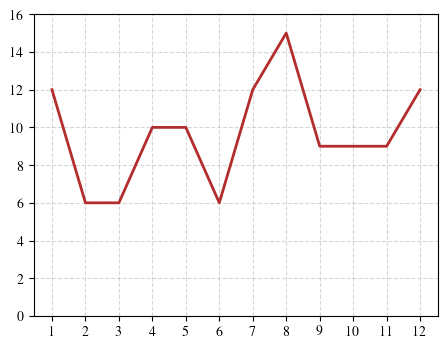

In [66]:
# Skupne ure za vsa poročila:
hours = [12, 6, 6, 10, 10, 6, 12, 15, 9, 9, 9, 12]
print(sum(hours))
plt.plot([i for i in range(1, 13)], hours)
plt.xticks([i for i in range(1, 13)])
plt.ylim(0, 16)
plt.show()